<a href="https://colab.research.google.com/github/MichaelArbel/KCEF/blob/master/KL_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install dm-sonnet==2.0.0b0 gast==0.2.2 tqdm
!pip install -q seaborn -U
!pip install --upgrade tensorflow-probability

     |████████████████████████████████| 911kB 4.6MB/s 
ERROR: graph-nets 1.0.5 has requirement dm-sonnet<2, but you'll have dm-sonnet 2.0.0b0 which is incompatible.
  Found existing installation: dm-sonnet 1.35
    Uninstalling dm-sonnet-1.35:
      Successfully uninstalled dm-sonnet-1.35
     |████████████████████████████████| 2.5MB 4.9MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.8.0 which is incompatible.
ERROR: gym 0.15.4 has requirement cloudpickle~=1.2.0, but you'll have cloudpickle 1.1.1 which is incompatible.
  Found existing installation: cloudpickle 1.2.2
    Uninstalling cloudpickle-1.2.2:
      Successfully uninstalled cloudpickle-1.2.2
  Found existing installation: tensorflow-probability 0.7.0
    Uninstalling tensorflow-probability-0.7.0:
      Successfully uninstalled tensorflow-probability-0.7.0


In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import sys
assert sys.version_info >= (3, 6), "Sonnet 2 requires Python >=3.6"

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import tensorflow as tf
import sonnet as snt

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow_probability as tfp
import bisect

tfd = tfp.distributions
tfb = tfp.bijectors
from enum import Enum

from collections.abc import Iterable

In [0]:
print("TensorFlow version: {}".format(tf.__version__))
print("    Sonnet version: {}".format(snt.__version__))
print("    Tfp version: {}".format(tfp.__version__))

TensorFlow version: 2.0.0
    Sonnet version: 2.0.0b0
    Tfp version: 0.8.0


In [0]:
sns.set(rc={"lines.linewidth": 2.8}, font_scale=2)
sns.set_style("whitegrid")

In [0]:
# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Define the distributions

In [0]:
dist1 = tfd.Normal(0, 1)
dist2 = tfd.Normal(5, 10)

In [0]:
true_kl = dist1.kl_divergence(dist2)

In [0]:
print(true_kl.numpy())

1.9325851


## Plot base distributions

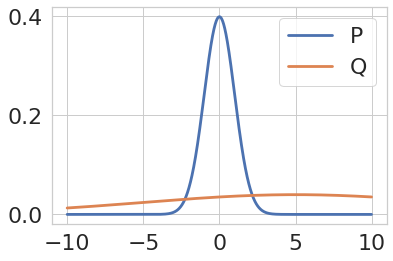

In [0]:
a = np.arange(-10, 10, 0.01)

plt.plot(a, dist1.prob(a), label='P')
plt.plot(a, dist2.prob(a), label='Q')
plt.legend()

## Distributional transforms

## Flows 

In [0]:
class SplineParams(object):

  def __init__(self, nbins=32, range_min=-5, num_units=1, name='SplineParams'):
    self._nbins = nbins
    self._built = False
    self._num_units = num_units
    self._range_min = range_min
    self._bin_widths = None
    self._bin_heights = None
    self._knot_slopes = None

  def _bin_positions(self, x):
    x = tf.reshape(x, [-1, self._nbins])
    size = 2 * np.abs(self._range_min)
    return tf.math.softmax(x, axis=-1) * (size - self._nbins * 1e-2) + 1e-2

  def _slopes(self, x):
    x = tf.reshape(x, [-1, self._nbins - 1])
    return tf.math.softplus(x) + 1e-2

  def _initialize(self):
    # Random spline initialization.
    self._bin_widths = self._bin_positions(
        tf.random.uniform((self._num_units, self._nbins), minval=0, maxval=1.))
    self._bin_heights = self._bin_positions(
        tf.random.uniform((self._num_units, self._nbins), minval=0, maxval=1.))
    self._knot_slopes = self._slopes(
        tf.random.uniform((self._num_units, self._nbins -1), minval=-1, maxval=5.))
    
  def __call__(self):
    self._initialize()
    return tfb.RationalQuadraticSpline(
        bin_widths=self._bin_widths,
        bin_heights=self._bin_heights,
        knot_slopes=self._knot_slopes,
        range_min=self._range_min,
        validate_args=True)



In [0]:
def random_spline_flow_stack(layers=13):
  chain = []
  for _ in range(layers):
    chain.append(SplineParams()())
  
  stack = tfp.bijectors.Chain(chain)
  return stack

In [0]:
id_transform = tfp.bijectors.Identity()
flow_transform = random_spline_flow_stack()

In [0]:
stack = flow_transform
xs = dist1.sample((10, 1))

ys = stack.forward(xs)
xs_hat = stack.inverse(ys)
assert xs_hat.shape == xs.shape
# Check what we built is actually a flow.
np.allclose(xs, xs_hat)

True

## Scrambled transforms

In [0]:
class ScrambledTransform(tfb.bijector.Bijector):

  def __init__(self, range_min, nbins):
    self._range_min = range_min
    self._nbins = nbins

    self._x_bins = self._bins()
    y_bins = self._bins()
    y_bins = list(zip(y_bins[:-1], y_bins[1:]))
    self._y_bins = np.random.permutation(y_bins)

    super(ScrambledTransform, self).__init__(
          dtype=tf.float32,
          forward_min_event_ndims=0,
          validate_args=True,
          name="scrambled_transform")

  def _bins(self):
    x = tf.random.uniform(shape=(self._nbins, ), minval=0, maxval=1)
    size = 2 * np.abs(self._range_min)
    b = tf.math.softmax(x, axis=-1) * (size - self._nbins * 1e-2) + 1e-2
    b = np.cumsum(b) 
    return np.concatenate((np.zeros((1, )), b)) + self._range_min

  def _one_forward_linear_params(self, x):
    # Search for x - if outside the modelled interval, return x.
    if x <= self._range_min or x > - self._range_min:
      return (1, 0)

    # find the x axis interval
    x_index = bisect.bisect_left(self._x_bins, x)

    assert x_index > 0, x
    # Note: this can happen due to numerical instabilities.
    # For example, if the last bin value is 5, 
    # bisect will return len(self._x_bins) for 4.999999999991687.
    if x_index == len(self._x_bins):
      return (1, 0)

    x1 = self._x_bins[x_index - 1]
    x2 = self._x_bins[x_index]
    y1, y2 = self._y_bins[x_index - 1]

    a = (y1 - y2) / (x1 - x2)
    b =  y1 - a * x1
    return (a, b)

  def _forward_linear_params(self, x):
    if not isinstance(x, Iterable):
      return self._one_forward_linear_params(x)
    
    a, b = zip(*[self._one_forward_linear_params(t) for t in x])
    return np.array(a), np.array(b)

  def __call__(self, x):
    return self.forward(x)

  def forward(self, x):
    a, b = self._forward_linear_params(x)
    y = a * x + b
    assert y.shape == x.shape
    return y

  def inverse(self, y):
    a, b = self._inverse_linear_params(y)
    return a * y + b

  def _inverse_linear_params(self, y):
    if not isinstance(y, Iterable):
      return self._one_inverse_linear_params(y)
    
    a, b = zip(*[self._one_inverse_linear_params(t) for t in y])
    return np.array(a), np.array(b)

  def _one_inverse_linear_params(self, y):
    if y <= self._range_min or y >= - self._range_min:
      return (1, 0)

    for y_index, (y1, y2) in enumerate(self._y_bins):
      if y1 <= y and y < y2:
        break

    x1 = self._x_bins[y_index]
    x2 = self._x_bins[y_index + 1]
    a = (y1 - y2) / (x1 - x2)
    b =  y1 - a * x1
    return (1./ a, - b/a)

  def _forward_log_det_jacobian(self, x):
     slope = self._forward_linear_params(x)[1]
     return tf.math.log(tf.abs(slope))

  def _inverse_log_det_jacobian(self, y):
     slope = self._inverse_linear_params(y)[1]
     return tf.math.log(tf.abs(slope))


In [0]:
scrambled_transform = ScrambledTransform(-5, 30)

### Check scrambled transform is invertible

In [0]:
xs = dist1.sample((1000, 1))
xs = np.arange(-10, 10, 0.001)
ys = scrambled_transform.forward(xs)
xs_hat = scrambled_transform.inverse(ys)

print(np.isclose(xs, xs_hat))
assert np.allclose(xs, xs_hat)

[ True  True  True ...  True  True  True]


## Choose and plot transform

In [0]:
transform = id_transform
transform = flow_transform
transform = scrambled_transform

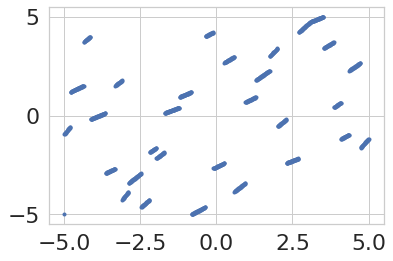

In [0]:
x = np.linspace(-5, 5, 1000)
y = transform.forward(x)
assert x.shape == y.shape
plt.plot(x, y, '.')

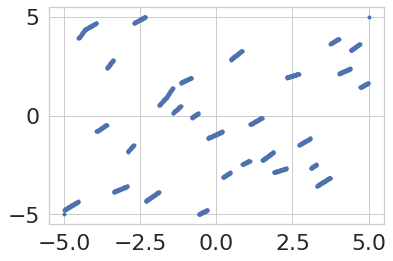

In [0]:
x = np.linspace(-5, 5, 1000)
y = transform.inverse(x)
plt.plot(x, y, '.')

## Construct the transform distributions

In [0]:
transformed_dist1 = tfd.TransformedDistribution(dist1, bijector=transform)
transformed_dist2 = tfd.TransformedDistribution(dist2, bijector=transform)

# Estimating KL divergences

## Monte Carlo

First to Monte Carlo estimation for the KL.

In [0]:
def monte_carlo_estimation(d1, d2, num_samples=10000):
  s = d1.sample(num_samples)
  return tf.reduce_mean(d1.log_prob(s) - d2.log_prob(s))

### Check out the value of the Monte Carlo estimation of the KL

In [0]:
print(true_kl)
print(monte_carlo_estimation(dist1, dist2))
print(monte_carlo_estimation(transformed_dist1, transformed_dist2))

tf.Tensor(1.9325851, shape=(), dtype=float32)
tf.Tensor(1.926148, shape=(), dtype=float32)
tf.Tensor(1.9301856, shape=(), dtype=float32)


## Critic

In [0]:
T = snt.Sequential([
    snt.Linear(200),
    tf.nn.relu,
    snt.Linear(200),
    tf.nn.relu,
    snt.Linear(1),
])

## F divergence formulation

In [0]:
BATCH_SIZE = 100
NUM_UPDATES = 1000

In [0]:
opt = snt.optimizers.Adam(learning_rate=0.001)

In [0]:
def estimate_kl(sample_size):
  d1 = T(transform(dist1.sample(sample_size)))
  d2 = tf.exp(T(transform(dist2.sample(sample_size))))
  return tf.reduce_mean(1 + d1 - d2)

In [0]:
def step():
  with tf.GradientTape() as tape:
    estimated_kl = estimate_kl((BATCH_SIZE, 1))
    estimated_kl = tf.reduce_mean(estimated_kl)
    loss = - estimated_kl
    params = T.trainable_variables
    grads = tape.gradient(loss, params)
    opt.apply(grads, params)

In [0]:
for i in range(NUM_UPDATES):
  step()
  if i % 10 == 0:
    print(estimate_kl((1000, 1)))

tf.Tensor(-0.1269374, shape=(), dtype=float32)
tf.Tensor(-1.58819, shape=(), dtype=float32)
tf.Tensor(-2.0071807, shape=(), dtype=float32)
tf.Tensor(-2.30271, shape=(), dtype=float32)
tf.Tensor(-2.1795342, shape=(), dtype=float32)
tf.Tensor(-2.1819625, shape=(), dtype=float32)
tf.Tensor(-2.1069982, shape=(), dtype=float32)
tf.Tensor(-2.1074703, shape=(), dtype=float32)
tf.Tensor(-2.0036197, shape=(), dtype=float32)
tf.Tensor(-1.8766478, shape=(), dtype=float32)
tf.Tensor(-1.766824, shape=(), dtype=float32)
tf.Tensor(-1.6063609, shape=(), dtype=float32)
tf.Tensor(-1.4424753, shape=(), dtype=float32)
tf.Tensor(-1.3134058, shape=(), dtype=float32)
tf.Tensor(-1.0023471, shape=(), dtype=float32)
tf.Tensor(-0.9270718, shape=(), dtype=float32)
tf.Tensor(-0.9574896, shape=(), dtype=float32)
tf.Tensor(-0.54712665, shape=(), dtype=float32)
tf.Tensor(-0.45746773, shape=(), dtype=float32)
tf.Tensor(-0.30399677, shape=(), dtype=float32)
tf.Tensor(0.06304458, shape=(), dtype=float32)
tf.Tensor(0.283

# Non bijectors transformations - same logic, just slightly different code and the inverse is not built

## Polynomial monotonic functions

In [0]:
def polinomial_transformation_builder(D, max_coeff_val=0.01):
  """ Only use odd degrees to ensure everything is monotonic."""
  coeff = np.random.rand(D) * max_coeff_val
  b = np.random.randn()

  def transform(x):
    power = x
    res = b
    for d in range(D):
      res += power * coeff[d]
      power = power * x **2

    return res

  return transform

In [0]:
polinomial_transformation = polinomial_transformation_builder(3)

In [0]:
polinomial_transformation(-1)

-1.0536866861788359

In [0]:
polinomial_transformation(-4.95)

-6.440746755521486

(1000,)
(1000,)


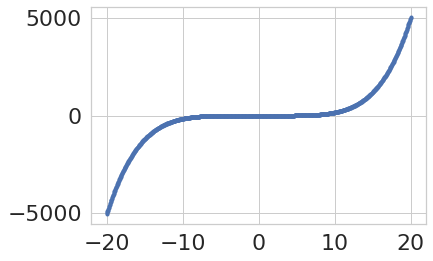

In [0]:
x = np.linspace(-20, 20, 1000)
y = polinomial_transformation(x)
print(y.shape)
print(x.shape)
assert x.shape == y.shape
plt.plot(x, y, '.')

## Random monotonic function


In [0]:
def monotonic_fourier(x, a, b, alpha, lmbda, L):
    # This function takes as input N vectors x of dimension d and outputs a applies a random point-wise non linearity on each dimension (x)_i  
    # such that f(x_i) is an increasing function of x. 
    #out(x) = b + sum a_i a_j \psi_{i,j}(x)
    # \psi_{i,j}(x) = sin( \lambda_ij^- (x+L)  )/(2L \lambda_ij^{-}) - sin( \lambda_ij^+ (x+L)  )/(2L \lambda_ij^{+})    
    # This implements the procedure in : 'A non-parametric probabilistic model for monotonic functions'

    # a : J x d  vecotr
    # b : d vector 
    # x : N x d  vector
    # out: N x d vector

    # Make a copy of the input array
    x  = np.array(x)
    J,d = a.shape
    # compute lmbda
    # lmbda = 1.*np.array(range(J))+1
    # lmbda *=np.pi/(2*L)
    # lmbda = np.power(lmbda, alpha)
    lmbda = (np.arange((J)) + 1) * 0.01 
    #lmbda = abs(lmbda)
    x += L 
    lmbda_x = np.einsum('i,nd->ind', lmbda , x )
    a_sin_x = np.einsum('id,ind->ind',a,np.sin(lmbda_x))
    a_cos_x = np.einsum('id,ind->ind',a,np.cos(lmbda_x))

    # Denominator for Psi plus.
    lmbda_ij_plus = np.expand_dims(lmbda,axis=0)+ np.expand_dims(lmbda,axis=1) 
    lmbda_ij_plus = 1./(lmbda_ij_plus)

    # Denominator for Psi_minus.
    lmbda_ij_minus = np.expand_dims(lmbda,axis=1) - np.expand_dims(lmbda,axis=0)
    # Special case for i = j. 
    lmbda_ij_minus = (1./(lmbda_ij_minus + np.eye(J)) - np.eye(J))

    # Sin((\lambda_i - \lambda_j) x) 
    #    = 1/2 (Sin(\lambda_i x)cos(\lambda_j x) + cos(\lambda_i x)sin(\lambda_j x))
    Psi_plus = 2.*np.einsum('ind,jnd,ij->nd', a_cos_x, a_sin_x, lmbda_ij_plus)
    Psi_minus = 2.*np.einsum('ind,jnd,ij->nd', a_sin_x,a_cos_x,lmbda_ij_minus)

    # Positive part of psi_{ii}
    diag_term = np.einsum('nd,d->nd',x,np.sum(a**2,axis = 0))
    out = Psi_minus - Psi_plus + diag_term 
    out /= 2*L
    
    return out + np.expand_dims(b,axis = 0)

In [0]:
D = 1
J = 100

# a = np.clip(np.random.randn(J, D), -0.5, 0.5)
a = np.array([1.] * int((J-2)/2) + [1.] * int((J-2)/2) + [1., 0.])
print(a.shape)
# lmbda = np.ones((J))
# lmbda = 1.*np.array(range(J))+1
# lmbda *=np.pi/(2*L)
# lmbda = np.power(lmbda, alpha)
a = np.expand_dims(a, axis=0)
b = 1

alpha = 1

# b constant offset for the function.

# L also gives higer values for frequencies.
L = 1

def monotonic_transform(x):
  f = lambda x: monotonic_fourier(x, a, b, alpha, lmbda, L)
  if not isinstance(x, Iterable):
      x = np.ones((1, 1)) * x
      return f(x)[0, 0]
  if x.ndim == 1:
    x = np.expand_dims(x, axis=1)
    return f(x)[:, 0]

  return f(x)

(100,)


(-5, 5)

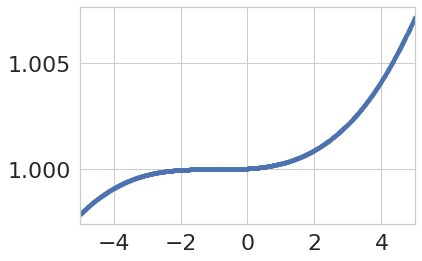

In [0]:
x = np.linspace(-5, 5, 1000)
y = monotonic_transform(x)
assert x.shape == y.shape
x = np.linspace(-5, 5, 1000)
plt.plot(x, y, '.')
plt.xlim((-5, 5))

In [0]:
D = 1
J = 10

# a = np.clip(np.random.randn(J, D), -0.5, 0.5)
a = np.flip(((np.arange(J)))) * 0.01
# a = np.concatenate((np.zeros((25, )), np.ones((25, )))) * 0.1
a = np.expand_dims(a, axis=0)
b = 1

alpha = 0.01

# A gives you the weights for the frequencies. If you sort a, you should get similar
# magintude but different frequencies.
# a = np.random.uniform(J, D)  * np.random.choice([-1, 1], ((J, D))) * 0.1

# b constant offset for the function.
# b = np.random.uniform(D) * np.random.choice([-1, 1], (D)) * 0.5
# L also gives higer values for frequencies (but it i less sensitive to the input)
L = 5


def monotonic_transform(x):
  f = lambda x: monotonic_fourier(x, a, b, alpha, lmbda, L)
  if not isinstance(x, Iterable):
      x = np.ones((1, 1)) * x
      return f(x)[0, 0]
  if x.ndim == 1:
    x = np.expand_dims(x, axis=1)
    return f(x)[:, 0]

  return f(x)

In [0]:
D = 1
J = 100

a = np.clip(np.random.randn(J, D), -0.5, 0.5)
b = 1

alpha = 0.2

# A gives you the weights for the frequencies. If you sort a, you should get similar
# magintude but different frequencies.
a = np.random.uniform(J, D)  * np.random.choice([-1, 1], ((J, D))) * 0.01

# b constant offset for the function.
b = np.random.uniform(D) * np.random.choice([-1, 1], (D)) * 0.5
# L also gives higer values for frequencies (but it i less sensitive to the input)
L = 1


def monotonic_transform(x):
  f = lambda x: monotonic_fourier(x, a, b, alpha, L)
  if not isinstance(x, Iterable):
      x = np.ones((1, 1)) * x
      return f(x)[0, 0]
  if x.ndim == 1:
    x = np.expand_dims(x, axis=1)
    return f(x)[:, 0]

  return f(x)

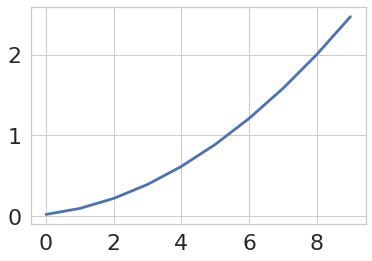

In [0]:
lmbda = 1.*np.array(range(J))+1
lmbda *=np.pi/(2*L)

alpha = 2
lmbda = np.power(lmbda, alpha)

plt.plot(lmbda)

In [0]:
monotonic_transform(1.)

2.0435986286291876

(-5, 5)

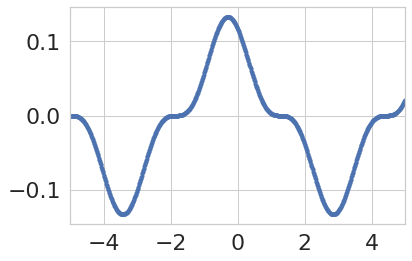

In [0]:
delta = 1
l1 = 1.
l2 = l1 + delta
L = 5.
x = np.linspace(-5, 5, 1000)
y  = np.sin ( (l1 + l2) * (x+L)) / (l1 + l2) - np.sin ( (l1 - l2) * (x+L)) / (l1 - l2)

y = y * 1./(2 * L)

x = np.linspace(-5, 5, 1000)
plt.plot(x, y, '.')
plt.xlim((-5, 5))

In [0]:
def small_monotonic_fourier(x, L):
    # This function takes as input N vectors x of dimension d and outputs a applies a random point-wise non linearity on each dimension (x)_i  
    # such that f(x_i) is an increasing function of x. 
    #out(x) = b + sum a_i a_j \psi_{i,j}(x)
    # \psi_{i,j}(x) = sin( \lambda_ij^- (x+L)  )/(2L \lambda_ij^{-}) - sin( \lambda_ij^+ (x+L)  )/(2L \lambda_ij^{+})    
    # This implements the procedure in : 'A non-parametric probabilistic model for monotonic functions'

    # a : J x d  vecotr
    # b : d vector 
    # x : N x d  vector
    # out: N x d vector

    # Make a copy of the input array
    x  = np.array(x)
    d = 1
    # compute lmbda
    # lmbda = 1.*np.array(range(J))+1
    # lmbda *=np.pi/(2*L)
    # lmbda = np.power(lmbda, alpha)
    lmbda = np.array([1., 2., 5.])
    a = np.array([[1., 2., 2.]]).T
    J = a.shape[0]
    #lmbda = abs(lmbda)
    x += L 
    lmbda_x = np.einsum('i,nd->ind', lmbda , x )
    a_sin_x = np.einsum('id,ind->ind',a,np.sin(lmbda_x))
    a_cos_x = np.einsum('id,ind->ind',a,np.cos(lmbda_x))

    # Denominator for Psi plus.
    lmbda_ij_plus = np.expand_dims(lmbda,axis=0)+ np.expand_dims(lmbda,axis=1) 
    lmbda_ij_plus = 1./(lmbda_ij_plus)

    # Denominator for Psi_minus.
    lmbda_ij_minus = np.expand_dims(lmbda,axis=1) - np.expand_dims(lmbda,axis=0)
    # Special case for i = j. 
    lmbda_ij_minus = (1./(lmbda_ij_minus + np.eye(J)) - np.eye(J))

    # Sin((\lambda_i - \lambda_j) x) 
    #    = 1/2 (Sin(\lambda_i x)cos(\lambda_j x) + cos(\lambda_i x)sin(\lambda_j x))
    Psi_plus = 2.*np.einsum('ind,jnd,ij->nd', a_cos_x, a_sin_x, lmbda_ij_plus)
    Psi_minus = 2.*np.einsum('ind,jnd,ij->nd', a_sin_x,a_cos_x,lmbda_ij_minus)

    # Positive part of psi_{ii}
    diag_term = np.einsum('nd,d->nd',x,np.sum(a**2,axis = 0))
    out = Psi_minus - Psi_plus + diag_term 
    out /= 2*L
    
    return out + np.expand_dims(b,axis = 0)

(-5, 5)

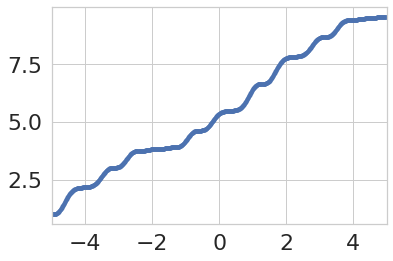

In [0]:
x = np.linspace(-5, 5, 1000)
x = np.expand_dims(x, axis=1)
y = small_monotonic_fourier(x, 5)
assert x.shape == y.shape
x = np.linspace(-5, 5, 1000)
plt.plot(x, y, '.')
plt.xlim((-5, 5))

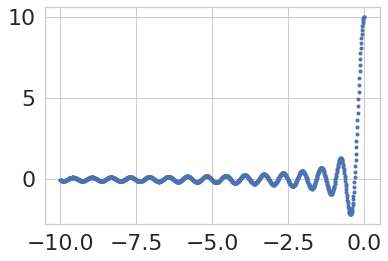

In [0]:
x = np.linspace(0.01, 10, 1000)
x = np.linspace(-10, 0.01, 1000)
k = 3
y = np.sin(x * 10) / x
assert x.shape == y.shape
plt.plot(x, y, '.')

## Training the estimator

In [0]:
transform = monotonic_transform
# transform = lambda x: flow_transform.forward(x)
# transform = polinomial_transformation

In [0]:
def squash_fn():
  return tf.nn.tanh

  def sq(x):
    return np.clip(x, -5, 5)
  return sq

In [0]:
T = snt.Sequential([
    # squash_fn(),
    snt.Linear(200),
    tf.nn.relu,
    snt.Linear(200),
    tf.nn.relu,
    snt.Linear(1),
])

In [0]:
BATCH_SIZE = 100
NUM_UPDATES = 10000

In [0]:
opt = snt.optimizers.Adam(learning_rate=0.001)

In [0]:
# print(T(polinomial_transformation(dist1.sample((100, 1)))))
print(T(transform(dist1.sample((100, 1)))).numpy().max())
print(T(transform(dist2.sample((100, 1)))).numpy().max())

0.515563519399465
0.5788688324065243


In [0]:
def estimate_kl(sample_size):
  d1 = T(transform(dist1.sample(sample_size)))
  d2 = tf.exp(T(transform(dist2.sample(sample_size))))
  return tf.reduce_mean(1 + d1 - d2)

In [0]:
def step():
  with tf.GradientTape() as tape:
    estimated_kl = estimate_kl((BATCH_SIZE, 1))
    estimated_kl = tf.reduce_mean(estimated_kl)
    loss = - estimated_kl
    params = T.trainable_variables
    grads = tape.gradient(loss, params)
    opt.apply(grads, params)

In [0]:
for i in range(NUM_UPDATES):
  step()
  if i % 10 == 0:
    print(estimate_kl((1000, 1)))

tf.Tensor(0.1811950524820844, shape=(), dtype=float64)
tf.Tensor(1.1109933190614887, shape=(), dtype=float64)
tf.Tensor(1.453438282320515, shape=(), dtype=float64)
tf.Tensor(1.7643802456983673, shape=(), dtype=float64)
tf.Tensor(1.8438693709363745, shape=(), dtype=float64)
tf.Tensor(1.6591632257240438, shape=(), dtype=float64)
tf.Tensor(1.6919335389555854, shape=(), dtype=float64)
tf.Tensor(1.7941666303548636, shape=(), dtype=float64)
tf.Tensor(1.755046371600454, shape=(), dtype=float64)
tf.Tensor(1.7293219842949157, shape=(), dtype=float64)
tf.Tensor(1.8026006551840696, shape=(), dtype=float64)
tf.Tensor(1.776207510873087, shape=(), dtype=float64)
tf.Tensor(1.6616842880283897, shape=(), dtype=float64)
tf.Tensor(1.9125003138821883, shape=(), dtype=float64)
tf.Tensor(1.7213673041215338, shape=(), dtype=float64)
tf.Tensor(1.820929811558679, shape=(), dtype=float64)
tf.Tensor(1.6905451985966995, shape=(), dtype=float64)
tf.Tensor(1.7993135129933642, shape=(), dtype=float64)
tf.Tensor(1.43

KeyboardInterrupt: ignored

In [0]:
print(estimate_kl((1000, 1)))

## Smoothness measure

In [0]:
x = np.linspace(-5, 5, 1000)
y = polinomial_transformation(x)

In [0]:
coef = np.fft.rfft(y)
# Remove the negative ones.
freqs = np.fft.fftfreq(len(x))[: (len(coef)-1)]

In [0]:
coef = np.expand_dims(coef, 1)
np.linalg.norm(coef, axis=1)

array([1283.73461635,  322.52504951,  394.81137993,  332.41568841,
        269.71690578,  223.64544521,  190.00600942,  164.76288737,
        145.25562509,  129.78356326,  117.23752337,  106.87222141,
         98.17171903,   90.76893729,   84.39624997,   78.85427441,
         73.99160128,   69.69128453,   65.86162199,   62.42972794,
         59.33696434,   56.53563566,   53.98655942,   51.65725415,
         49.52056988,   47.55364031,   45.73707212,   44.05431123,
         42.49114266,   41.03529229,   39.67610713,   38.40429668,
         37.21172223,   36.09122396,   35.03647829,   34.04187943,
         33.10244043,   32.21371022,   31.37170357,   30.57284176,
         29.81390211,   29.0919748 ,   28.40442585,   27.74886522,
         27.12311921,   26.52520656,   25.95331766,   25.40579629,
         24.8811238 ,   24.37790508,   23.89485626,   23.43079386,
         22.98462517,   22.55533969,   22.1420016 ,   21.74374291,
         21.35975752,   20.98929572,   20.63165941,   20.28619